In [8]:
import pandas as pd
import numpy as np

import konlpy
# konlpy tweepy관련 오류 발생하면 3.10.0 downgrade
# !pip install tweepy==3.10.0

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv('../nlp_poem.csv')
poem = data

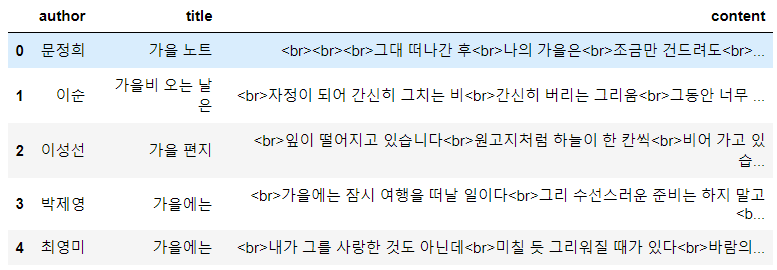

# 데이터 전처리

In [12]:
stopwords = [
    "stop", "words"
]

In [18]:
from konlpy.tag import Okt
tagger = Okt()

# 시 내용 가져오기
contents = poem['content']

시 내용 리스트로 저장


def preprocessing(text):
    # <br>제거
    text = text.replace("<br>", " ")
    
    # 형태소 분석
    okt_pos = tagger.pos(text, norm=True, stem=True)
    
    # 명사, 동사, 형용사만 사용
    words = [word for word, hts in okt_pos if hts in ['Noun','Adjective', 'Verb']]
    
    # 스탑 워드 적용
    words = [word for word in words if word not in stopwords]
    
    #리스트 문자열로 변경
    pure_string = ' '.join(words)
    
    return pure_string

content = list(contents.apply(preprocessing))

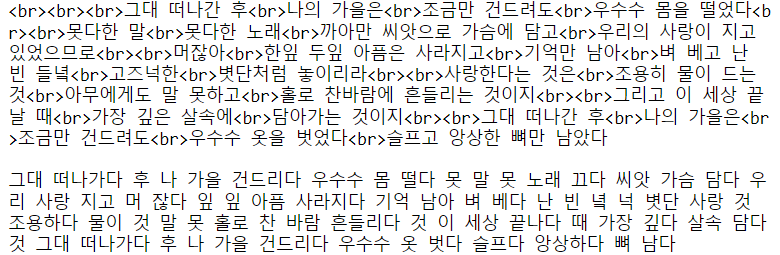

# 자주 등장하는 단어 계산, tf-idf

In [22]:
"""
    모든 시에서 단어를 추출(14438개),
    각 시에 대해서 하나의 단어가 얼만큼 가중치가 있는지 나타냄,
    이를 통해 시를 14438의 차원으로 벡터화가능
    
    이때 idf는 전체적으로 자주 등장하는 단어를 가중치를 낮게 준다.
    EX) '당신'이라는 단어가 전체 시에서 빈도수가 높아 가중치를 낮게,
        '사과'라는 단어는 전체 시에서 빈도수가 낮아 가중치를 높게,
        즉 가중치가 높은 순서대로 각 시의 중심 단어임을 추측할 수 있음
"""
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
words_vectors = vectorizer.fit_transform(content).toarray()

words_vectors = pd.DataFrame(words_vectors)

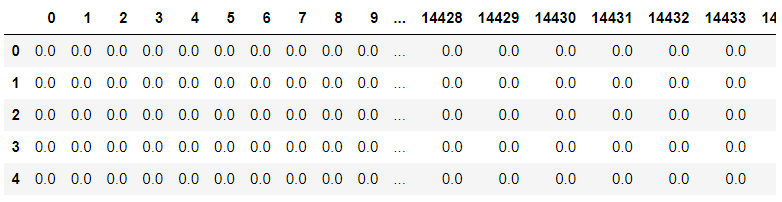

## tf-idf를 사용한 빈도수 기반 불용어 처리

In [24]:
def index_to_word(search_num):
    """tf-idf의 vocab이 매칭하는 숫자를 단어로 바꿔주는 함수,
       EX) 0번 단어 -> '사랑' 
    """
    words = vectorizer.vocabulary_
    
    for word, wordnum in words.items():
        if wordnum == search_num:
            return word

In [28]:
#불용어 처리 위한 상위 단어 리스트
index_sorted_string_list = []

for index in range(len(words_vectors)):
    arow = words_vectors.loc[index]
    arow = arow.sort_values(ascending=False)[0:20]
    
    for key, value in arow.items():
        if value != 0.0:
            index_sorted_string_list.append(index_to_word(key))

In [30]:
# Counter로 자주 등장하는 단어 보기
from collections import Counter
dict(Counter(index_sorted_string_list).most_common(1000))

# 자주 등장하는 단어에 불용어가 있으면 stopwords로 추가해서 불용어 처리
# "하다", "있다" 등등

''

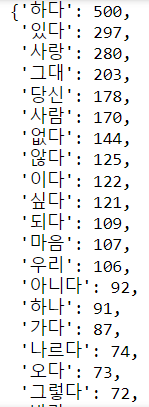

# PCA 주성분 개수 정하기

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=800) #n_components = 주성분의 개수

# PCA 변환 데이터 반환, 14000의 차원을 800차원으로 주성분 추출
poem_pca = pca.fit_transform(words_vectors)

In [ ]:
#variance_ratio = 축소한 주성분이 원본 데이터를 얼마나 표현가능한지 알려주는 지표
# 800차원으로 주성분을 추출했을 때, 0.703475% Cover가능함

variance_ratio = pd.DataFrame(pca.explained_variance_ratio_)
variance_ratio = variance_ratio.sort_values(by=0, ascending=False)
variance_ratio.sum(0)

# PCA reconstruct

In [33]:
def word_sorting(pcadata, word_num):
    sorted_data = []
    for index in range(len(pcadata)):
        arow = pcadata.loc[index]
        arow = arow.sort_values(ascending=False)[0:word_num]

        str_index = ""
        for key, value in arow.items():
            if value != 0.0:
                str_index = str_index + index_to_word(key) + ','
        
        sorted_data.append(str_index)

    return sorted_data

In [37]:
from tqdm import trange, notebook # show progress-bar, 진행도 출력

PCA_DIMENSION = words_vectors.shape[1] # 주성분 개수
clear_data = pd.DataFrame(words_vectors)

insight_dataframe = pd.DataFrame(columns=range(PCA_DIMENSION))
for dim in notebook.tqdm(range(PCA_DIMENSION)):
    poem_pca_dataframe = pd.DataFrame(columns=range(PCA_DIMENSION))
    poem_pca_dataframe[dim] = clear_data[dim]
    poem_pca_dataframe[poem_pca_dataframe.columns.difference([dim])] = 0 #PCA 개수 대로 나머지 0으로 변경
    
    #작은 순서대로 정렬 min to max 보기위해
    poem_pca_dataframe = poem_pca_dataframe.sort_values(by=dim)
    poem_pca_dataframe = poem_pca_dataframe.iloc[poem_pca_dataframe.index %4 == 0] # row 수 정리
    
    #reconstruct진행
    pca_inverse = pca.inverse_transform(poem_pca_dataframe.to_numpy())
    pca_inverse_dataframe = pd.DataFrame(pca_inverse)
    
    # 내포한 특징 단어 확인
    words_list = word_sorting(pca_inverse_dataframe, 5)
    insight_dataframe[dim] = words_list

KeyboardInterrupt: 

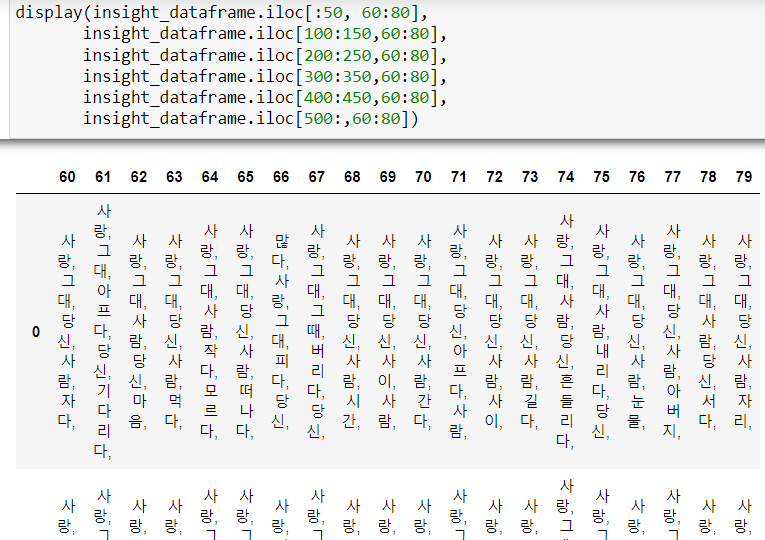

In [ ]:
"""
    사실은 여기까지 하고 위에 데이터를 보고 인사이트를 찾기 어려워서
    그냥 tf-idf로 전체 시에서 가장 많이 나온단어 1000개 정도 끊어서
    그 단어들 보면서 클래스 분류했음
"""